In [17]:
import pandas as pd, spacy, math
import matplotlib.pyplot as plt

from datetime import datetime
from gensim.utils import simple_preprocess
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from wordcloud import WordCloud

In [18]:
STOPWORDS = set(stopwords.words('english'))
ALLOWED_POSTAGS = ['NOUN', 'ADJ', 'VERB', 'ADV', 'PART']
NLP_MODELS = {
    'en_core_web_trf': spacy.load('en_core_web_trf'),    
    'en_core_web_sm': spacy.load('en_core_web_sm'),
    'en_core_web_md': spacy.load('en_core_web_md'),
    'en_core_web_lg': spacy.load('en_core_web_lg')
}

In [19]:
class Model:
    # not necesarry but just as a 'fyi'
    raw_data = [] # constructor
    stopwords = STOPWORDS # default if not given
    allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV']
    debug_history = dict()
    ngram_model = None
    words = []
    
    def __init__(self, df, steps
                 , num_topics=10
                 , nlp_model = 'en_core_web_lg'
                 , stopwords=STOPWORDS
                 , ngrams=2
                 , min_count=5
                 , threshold=10
                 , allowed_postags=ALLOWED_POSTAGS
                 , debug = False
                 , random_state=100
                 , update_every=1
                 , chunksize=100
                 , passes=10
                 , alpha='auto'
                 , per_word_topics=True
        ):
        self.steps = steps
        self.stopwords = stopwords
        self.num_topics = num_topics
        self.raw_data = df
        self.ngram = {'min_count': min_count, 'threshold': threshold, 'ngrams': ngrams}
        self.lda_model_params = {'random_state': random_state, 'update_every': update_every, 'chunksize': chunksize, 'passes': passes, 'alpha': alpha, 'per_word_topics': per_word_topics}
        self.allowed_postags = allowed_postags
        self.debug = debug
        if nlp_model not in NLP_MODELS:
            nlp_model = 'en_core_web_lg'
        self.nlp = NLP_MODELS[nlp_model]
    
    def fit(self):
        
        print(f'{datetime.now()}  start')

        # split sentences into array of words
        print(f'{datetime.now()}   sentences_as_words')
        result = self.sentences2words(self.raw_data)

        if (self.debug):
            self.debug_history['sentences_as_words'] = result
            
        # iterate the pipeline
        for step in self.steps:
            print(f'{datetime.now()}   {step}')

            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
                if (self.debug):
                    self.debug_history['words_without_stopwords'] = result

            elif step == 'lemmatization':
                result = self.lemmatization(result)
                if (self.debug):
                    self.debug_history['lemmas'] = result

            elif step == 'ngram':
                # train ngram model
                ngram_model = self.train_ngrams(result, ngrams=self.ngram['ngrams'], min_count=self.ngram['min_count'], threshold=self.ngram['threshold'])

                if len(ngram_model)>0:
                    self.ngram_model = ngram_model

                    # apply ngram model
                    result = self.create_ngrams(ngram_model, result)
                    if (self.debug):
                        self.debug_history['ngrams'] = result
                else:
                    print(f'{datetime.now()} ngram not done: {self.ngram["ngram"]}')

            else:
                print(f'{datetime.now()} instruction not found: {step}')
            
        # save all words per sentiment class
        words = self.array2dto1d(result)
        if (self.debug):
            self.debug_history['words'] = words
            
        dictionary = Dictionary([words])
        self.dictionary = dictionary
        
        corpus = [dictionary.doc2bow(text) for text in result]
        if (self.debug):
            self.debug_history['corpus'] = corpus
        
        self.lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=self.num_topics, 
            random_state=self.lda_model_params['random_state'],
            update_every=self.lda_model_params['update_every'],
            chunksize=self.lda_model_params['chunksize'],
            passes=self.lda_model_params['passes'],
            alpha=self.lda_model_params['alpha'],
            # beta=1,
            per_word_topics=self.lda_model_params['per_word_topics']
        )
        
        self.coherence_model_lda = CoherenceModel(
            model=self.lda_model
            , texts=result
            , dictionary=dictionary
            , coherence='c_v'
        )
        
        print(f'{datetime.now()} end')
        
    def predict_list(self, list_of_sentences, debug=False):
        results = []
        for sentence in list_of_sentences:
            results.append({'sentence': sentence, **self.predict(sentence, debug)})
        return results
    
    
    def predict(self, sentence, debug=False):
        """returns document topics"""
        sentences = [sentence]
        result = self.sentences2words(sentences)
        if debug:
            print(f'{datetime.now()} {result}')
            
        # apply pipeline to sentence
        for step in self.steps:
            if debug:
                print(f'{datetime.now()} {step}')
            if step == 'remove_stopwords':
                result = self.remove_stopwords(result)
            elif step == 'lemmatization':
                result = self.lemmatization(result)
            elif step == 'ngram':
                if (self.ngram_model != None and len(self.ngram_model)>0):                   
                    result = self.create_ngrams(self.ngram_model, result)
                else:
                    print(f'no ngram model found')
            else:
                print(f'instruction not found: {step}')
            if debug:
                print(f'{datetime.now()} {result}')
  
        words_bow = [self.dictionary.doc2bow(text) for text in result]
        return self.lda_model.get_document_topics(words_bow[0])      
    
    def sentences2words(self, sentences):
        """
        receives a list of strings (sentences) ['hello world', 'test, sentence!'] 
        and returns for each sentence a split of its words: [['hello','world'], ['test','sentence']]
        using gensim simple_preprocess function
        """
        words = []
        for sentence in sentences:
            words.append(simple_preprocess(sentence, deacc=True))
        return words
        
    def remove_stopwords(self, list_of_list_of_words):
        """
        receives a list of list of words [['abc', 'abc', ...], ...]
        """
        words = []
        for sentence_as_words in list_of_list_of_words:
            words.append([word for word in sentence_as_words if word not in self.stopwords])
        return words
            
    def lemmatization(self, list_of_list_of_words):
        """
        receives a list of list of words [['swimming','after','playing']]
        and returns the same list with each words lemma: [['swim','after','play']]
        """
        words = []        
        for sentence_as_words in list_of_list_of_words:
            doc = self.nlp(' '.join(sentence_as_words))
            words.append([token.lemma_ for token in doc if token.pos_ in self.allowed_postags ])
        return words
    
    def array2dto1d(self, array2d):
        """
        receives a list of list of words [['hello','world'],['test']] 
        and returns in a single list ['hello','world','test']
        """
        result = []
        for array1d in array2d:
            result.extend(array1d)
        return result
            
    def train_ngrams(self, list_of_list_of_words, ngrams=2, min_count=5, threshold=10):
        if ngrams < 2:
            ngrams = 2
        result = list_of_list_of_words
        ngram_models = []
        for i in range(ngrams-1):
            ngram_phraser = Phrases(result, min_count=min_count, threshold=threshold)
            ngram_model = Phraser(ngram_phraser)
            ngram_models.append(ngram_model)
            result = list(ngram_model[result])
            
        return ngram_models
    
    def create_ngrams(self, ngram_model_array, list_of_list_of_words):
        """ngram_model = []"""
        result = list_of_list_of_words
        for ngram_model in ngram_model_array:
            result = list(ngram_model[result])
        return result        

In [20]:
df = pd.read_csv('data/sample.csv')
data = df.review.values.tolist()

In [23]:
model = Model(
    data
    , ['remove_stopwords', 'lemmatization', 'ngram']
    , num_topics = 10
    , nlp_model = 'en_core_web_lg'
    , stopwords=STOPWORDS
    , ngrams=2
    , min_count=5
    , threshold=10
    , allowed_postags=ALLOWED_POSTAGS
    , debug = True
)
model.fit()

2022-07-09 13:03:46.606597  start
2022-07-09 13:03:46.606681   sentences_as_words
2022-07-09 13:03:46.609787   remove_stopwords
2022-07-09 13:03:46.609979   lemmatization
2022-07-09 13:03:46.833521   ngram
2022-07-09 13:03:46.954984 end


In [24]:
print(model.debug_history)

{'sentences_as_words': [['would', 'definitely', 'stay', 'here', 'again', 'in', 'antigua', 'it', 'was', 'perfect', 'the', 'property', 'is', 'beautiful', 'it', 'was', 'very', 'clean', 'and', 'comfortable', 'the', 'location', 'is', 'fantastic', 'there', 'great', 'rooftop', 'deck', 'and', 'the', 'people', 'are', 'very', 'friendly', 'there', 'are', 'cheaper', 'places', 'to', 'stay', 'paid', 'usd', 'quetzales', 'for', 'the', 'best', 'room', 'room', 'but', 'casa', 'cristina', 'is', 'worth', 'it', 'if', 'you', 'can', 'afford', 'it', 'use', 'the', 'tour', 'agency', 'at', 'the', 'hospedaje', 'next', 'door', 'for', 'transportation', 'they', 'will', 'recommend', 'them', 'at', 'the', 'front', 'desk', 'he', 'is', 'super', 'friendly', 'and', 'reliable', 'and', 'speaks', 'english', 'used', 'different', 'tour', 'booker', 'when', 'got', 'into', 'antigua', 'and', 'got', 'ripped', 'off', 'van', 'never', 'showed', 'up', 'but', 'he', 'salvaged', 'my', 'day', 'by', 'getting', 'replacement', 'transportation',

In [25]:
model.lda_model.print_topics()

[(0,
  '0.037*"fancy" + 0.020*"build" + 0.020*"space" + 0.020*"old" + 0.020*"say" + 0.020*"worn" + 0.020*"maybe" + 0.020*"park" + 0.020*"price" + 0.020*"converted"'),
 (1,
  '0.004*"stay" + 0.004*"great" + 0.004*"walk" + 0.004*"staff" + 0.004*"night" + 0.004*"minute" + 0.004*"clean" + 0.004*"nice" + 0.004*"go" + 0.004*"small"'),
 (2,
  '0.019*"great" + 0.019*"room" + 0.019*"staff" + 0.019*"walk" + 0.019*"location" + 0.019*"beautiful" + 0.019*"day" + 0.019*"clean" + 0.019*"recommend" + 0.018*"fi"'),
 (3,
  '0.033*"friendly" + 0.033*"transportation" + 0.033*"tour" + 0.033*"show" + 0.033*"use" + 0.017*"booker" + 0.017*"deck" + 0.017*"volcano" + 0.017*"super" + 0.017*"day"'),
 (4,
  '0.030*"hotel" + 0.016*"recently" + 0.016*"regret" + 0.016*"need" + 0.016*"clean" + 0.016*"absolutely" + 0.016*"never" + 0.016*"return" + 0.016*"cafe" + 0.016*"spotless"'),
 (5,
  '0.004*"review" + 0.004*"walk" + 0.004*"breakfast" + 0.004*"fresh" + 0.004*"stay" + 0.004*"return" + 0.004*"authentic" + 0.004*"hope

In [26]:
# model.lda_model.alpha
model.coherence_model_lda.get_coherence()

0.8076163836815944

In [27]:
model.predict('hello stay astdast', debug=True)

2022-07-09 13:03:56.199648 [['hello', 'stay', 'astdast']]
2022-07-09 13:03:56.200261 remove_stopwords
2022-07-09 13:03:56.200302 [['hello', 'stay', 'astdast']]
2022-07-09 13:03:56.200322 lemmatization
2022-07-09 13:03:56.213813 [['stay', 'astdast']]
2022-07-09 13:03:56.213874 ngram
2022-07-09 13:03:56.213963 [['stay', 'astdast']]


[(0, 0.026924526),
 (1, 0.017215881),
 (2, 0.02955506),
 (3, 0.027740393),
 (4, 0.02706025),
 (5, 0.018617827),
 (6, 0.026982583),
 (7, 0.028071536),
 (8, 0.7683267),
 (9, 0.029505268)]

In [28]:
def plot_cloud(model, export=False):
    topics_array = model.lda_model.get_topics()
    columns = 2
    rows = math.ceil(len(topics_array)/columns)
    
    fig, ax = plt.subplots(rows, columns, figsize = (18, 25))
    ax = ax.ravel()
    
    for topic_i in range(len(topics_array)):
        topic = topics_array[topic_i]
        wordcloud_text = {model.dictionary[i] : topic[i] for i in range(len(topic))} # i has the index of the dictionary
#         {'palabra': weight}
        
        # Generate wordcloud
        wordcloud = WordCloud(
            width = 1000
            , height = 500
            , background_color='white'
            , margin=2
        )

        wordcloud.fit_words(wordcloud_text)
     
        ax[topic_i].imshow(wordcloud)
        ax[topic_i].set_title(f'topic_{topic_i}')
        ax[topic_i].set_axis_off()
        
        if (export):
            # export as image
            wordcloud.to_file(f'images/topic_{topic_i}.png')   
    plt.show()

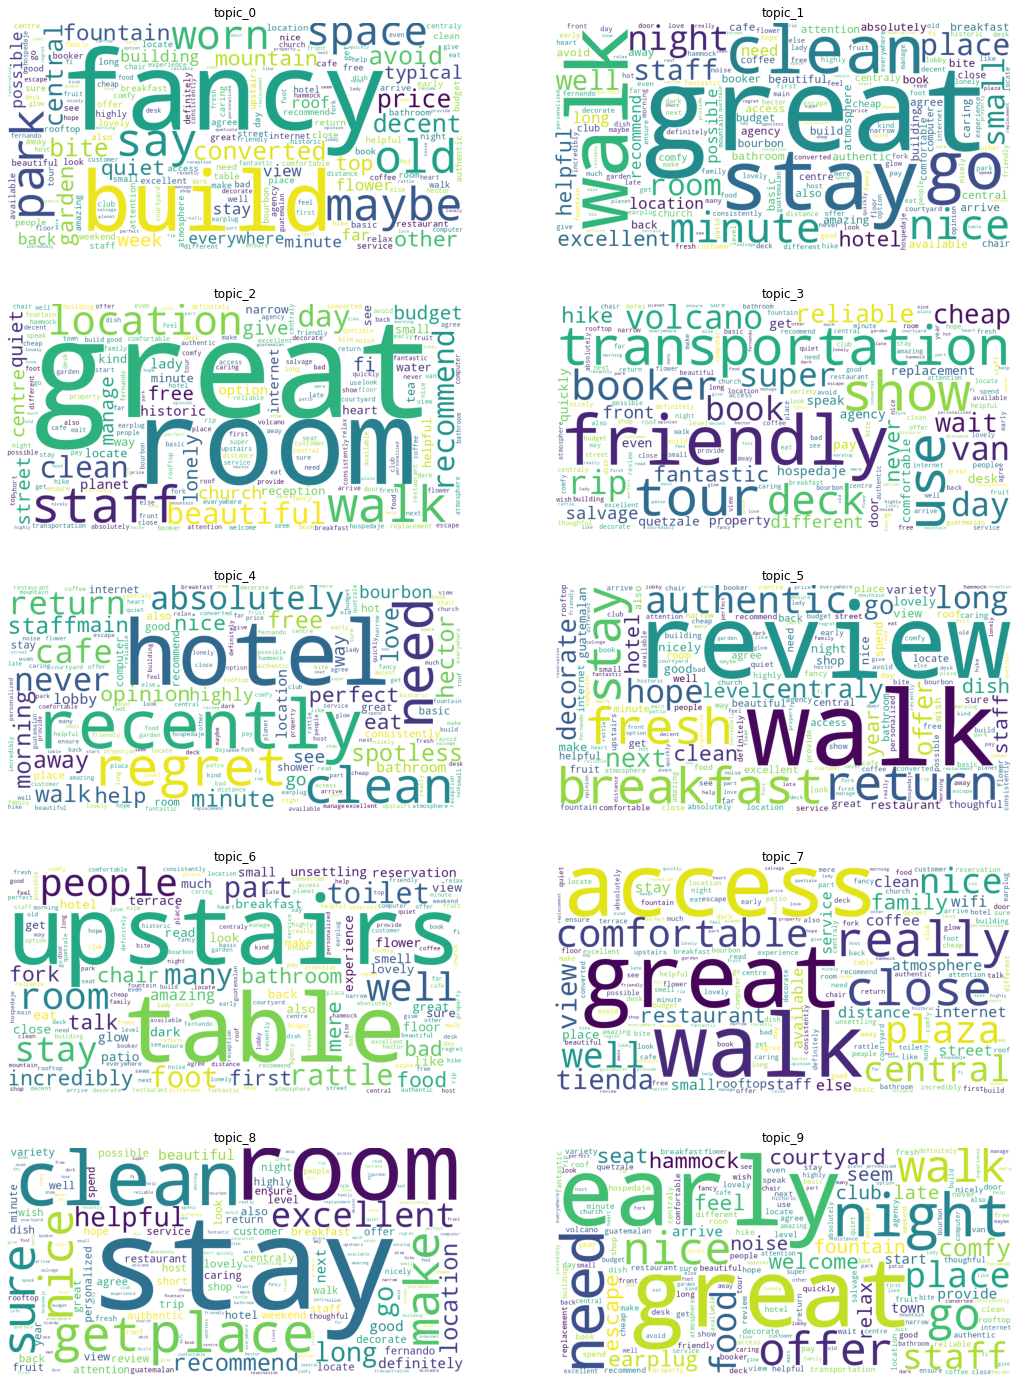

In [29]:
plot_cloud(model)